In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import re
import random

In [3]:
df_dc = pd.read_csv('../data/dc_job.csv')
df_usa = pd.read_csv('../data/usa_job.csv')
df_all = pd.read_csv('../data/all_job.csv')

In [4]:
df_all['Responsibilities']

0      Design, maintain and deploy smart contracts fo...
1      As a Blockchain Engineer, you will be responsi...
2      Our expert technical team will provide the sup...
3      Will discuss details with the selected candidates
4      To build a best-in-class Filecoin (FIL) Mining...
                             ...                        
818    The role will serve as a core member within th...
819    Conduct research on Natural Language Processin...
820    Lead proposals for new funding from government...
821    Define and own a roadmap of large-scale resear...
822    Successful applicants will work as part of a t...
Name: Responsibilities, Length: 823, dtype: object

In [5]:
def extract_years_of_experience(qualification):
    pattern = r'(\d+)\+?\s*(?:years|years of|\(.*?\)\s*years)'
    matches = re.findall(pattern, qualification, re.IGNORECASE)
    if matches:
        return min([int(match) for match in matches])
    else:
        return np.nan

# Create a new column 'YoE' to store the years of experience
df_all['Min YoE'] = df_all['Qualifications'].apply(lambda x: extract_years_of_experience(x))

In [21]:
np.where(df_all['Benefits'].str.contains('sponsor', case = False))

(array([ 30, 129, 132, 149, 208, 212, 562, 798]),)

In [6]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text with stemming and lemmatization
def preprocess(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

# Apply preprocessing to the 'Qualifications' column
df_all['Qualifications_processed'] = df_all['Qualifications'].apply(preprocess)

# Define original keywords
keywords = ['R', 'Python', 'NLP', 'SQL', 'Cloud', 'Deep Learning', 'Solidity', 'Visualization', 'Optimization', 'Financial']

# Search for original keywords in preprocessed text
for keyword in keywords:
    if keyword == 'R':
        df_all[keyword] = np.where(df_all['Qualifications'].str.contains(r'\bR\b'), True, False)
    else:
        df_all[keyword] = np.where(df_all['Qualifications_processed'].str.contains(preprocess(keyword), case=False), True, False)

df_all['Group'] = df_all['search'].apply(lambda text: re.sub(r'-\d+$', '', text).replace('-', ' ').title())

In [7]:
from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt

df = df_all[keywords]
df.rename(columns = {'NLP': "Natural Language Processing"})
transactions = []
for _, row in df.iterrows():
    transaction = [column for column in row.index if row[column] and column != 'Group']
    transactions.append(transaction)

In [8]:
def reformat_results(result):

    keep = []
    for i in range(0, len(result)):
        for j in range(0, len(list(result[i]))):
            if (j == 1):
                supp = result[i][j]
            if (j > 1):
                for k in range(0, len(list(result[i][j]))):
                    rhs = list(result[i][j][k][0])
                    if rhs:
                        lhs = list(result[i][j][k][1])
                        conf = float(result[i][j][k][2])
                        lift = float(result[i][j][k][3])
                        keep.append([rhs, lhs, supp, conf, supp*conf, lift])
    
    return  pd.DataFrame(keep, columns = ["rhs", "lhs", "supp", "conf", "supp x conf", "lift"])


def convert_to_network(df):


    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="+".join(row[1][0])
        rhs="+".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

def plot_network(G):

    random.seed(10)
    np.random.seed(10)
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edge_color=colors_e,
    node_size=4000,
    linewidths=2,
    font_size=8,
    font_color="black",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    edge_labels = {(u, v): "{:.4f}".format(G[u][v]['weight']) for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    ax.set(title='Skills in Qualification')
    plt.show()

In [9]:
results = list(apriori(transactions, min_support = 0.05, min_confidence = 0.3, min_length = 1, max_length = 5))

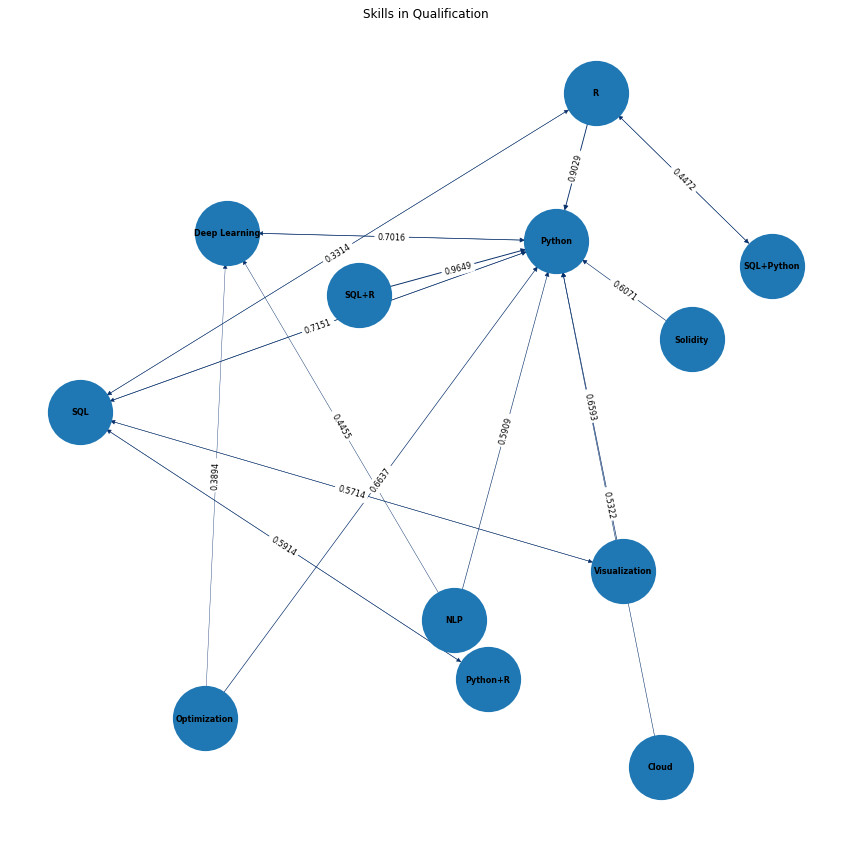

In [10]:

results_reforated = reformat_results(results)
results_net = convert_to_network(results_reforated)
plot_network(results_net)

In [11]:
# import pandas as pd
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
# import networkx as nx
# import matplotlib.pyplot as plt



# # Get the last item of each transaction as the consequents
# consequents = [transaction[-1] for transaction in transactions]

# # Apply one-hot encoding to the transaction list
# te = TransactionEncoder()
# te_array = te.fit_transform(transactions)
# df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# # Apply Apriori algorithm to find frequent itemsets
# frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)


# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
# rules['consequents'] = rules['consequents'].apply(lambda x: '+ '.join(list(x)))

# rules['antecedents'] = rules['antecedents'].apply(lambda x: '+ '.join(list(x)))
# rules = rules[rules['consequents'].apply(lambda x: x in consequents)]
# rules

In [12]:

# # Create a bipartite graph
# G = nx.Graph()

# # Add nodes (items and categories)
# G.add_nodes_from(rules['antecedents'], bipartite=0)
# G.add_nodes_from(rules['consequents'], bipartite=1)

# # Add edges between items and categories based on association rules
# for _, row in rules.iterrows():
#     antecedents = row['antecedents']
#     consequents = row['consequents']
#     G.add_edge(antecedents, consequents)

# # Create bipartite graph layout
# pos = nx.bipartite_layout(G, rules['antecedents'])

# # Draw the bipartite graph
# plt.figure(figsize=(10, 6))
# nx.draw_networkx_nodes(G, pos, nodelist=rules['antecedents'],
#     node_size=4000,
#     linewidths=2,node_color='blue')
    
# nx.draw_networkx_nodes(G, pos, nodelist=rules['consequents'],
#     node_size=4000,
#     linewidths=2,
# node_color='red')
# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos)
# plt.axis('off')
# plt.show()


In [13]:
# consequents = [transaction[-1] for transaction in transactions]
# consequents

In [27]:
df_all['location'][df_all['search_location'] == "DC"].value_counts().head(21)

 Anywhere                       69
  Washington, DC                40
  New York, NY                  21
  Arlington, VA                 18
  Herndon, VA                   13
  San Francisco, CA             12
  Bethesda, MD                  10
  McLean, VA                     9
  Annapolis Junction, MD         9
  United States                  9
  Alexandria, VA                 8
  Seattle, WA                    7
  Silver Spring, MD              7
  Fairfax, VA                    6
  Fort Meade, MD                 6
  Annapolis, MD                  6
  Reston, VA                     5
  Baltimore, MD                  5
  Chicago, IL                    4
  Cupertino, CA                  4
  South San Francisco, CA        4
Name: location, dtype: int64

In [28]:
df_all['location'][df_all['search_location'] == "USA"].value_counts().head(21)

 Anywhere                       108
  United States                  24
  New York, NY                   23
  San Francisco, CA              16
  Annapolis Junction, MD         12
  Chicago, IL                    11
  Palo Alto, CA                   9
  Los Angeles, CA                 8
  Seattle, WA                     7
  Cupertino, CA                   7
  San Jose, CA                    7
  Bentonville, AR                 6
  Oklahoma City, OK               5
  Menlo Park, CA                  5
  South San Francisco, CA         5
  Irving, TX                      5
  Boston, MA                      4
  Atlanta, GA                     4
  Santa Clara, CA                 4
  Washington, DC                  4
  Annapolis, MD                   4
Name: location, dtype: int64

In [15]:
df_all['schedule_type'].value_counts()

Full-time     719
Contractor     78
Internship     19
Part-time       6
Name: schedule_type, dtype: int64

In [16]:
df_all['wfh'].value_counts()

False    646
True     177
Name: wfh, dtype: int64

In [24]:
df_all['via'].value_counts().head(20)

via LinkedIn            66
via ZipRecruiter        60
via Upwork              56
via AngelList           36
via Lever               23
via Greenhouse          19
via Clearance Jobs      19
via Startup Jobs        16
via Built In            15
via Salary.com          14
via Jobs By Workable    13
via Careers At Apple    13
via Karkidi             12
via Glassdoor           12
via Snagajob            12
via Jooble              11
via Monster             11
via JobLeads            11
via LocalJobs.com       10
via Indeed              10
Name: via, dtype: int64

In [72]:
df_all['Group'].value_counts()

Block Chain                     90
Natural Language Processing     90
Big Data And Cloud Computing    90
Data Analyst                    90
Machine Learning                90
Reinforcement Learning          90
Neural Networks                 90
Deep Learning                   90
Data Scientist                  90
Time Series Analysis             7
Time Series                      6
Name: Group, dtype: int64